In [2]:
# Imports and config
import sys
sys.path.append("../src")
from precomputed_dataset import precomputedDataset
from model import MPNNTransformerModel

import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader as PyGDataLoader

config = {
    # Tier 1
    "lr": 1e-4,
    "mpnn_hidden_dim": 128,
    "mpnn_num_layers": 3,
    "attn_num_heads": 4,
    "attn_num_layers": 4,
    "token_dim": 128,
    "pooling_strategy": "cls_token",
    # Tier 2
    "weight_decay": 0.0,
    "dropout": 0.1,
    "mp_layer_norm": False,
    # Fixed
    "train_batch_size": 128,
    "val_batch_size": 256,
    "scheduler_min_lr": 5e-6,
    "head_mlp_hidden_dim": 256,
    "gradient_clip_max_norm": 1.0,
    "num_output_sources": 1,
    "node_in_dim": 6,
    "edge_in_dim": 6,
    # Training
    "epochs": 200,
    "seed": 0,
    "device": "cuda:2",
    "train_path": "/mnt/data/zaid/projects/simulated_data/step1.h5",
    "val_path": "/mnt/data/zaid/projects/simulated_data/validation.h5",
}

In [10]:
# Setup
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
torch.cuda.manual_seed_all(config["seed"])

device = config["device"]

train_ds = precomputedDataset(config["train_path"])
val_ds = precomputedDataset(config["val_path"])

train_loader = PyGDataLoader(train_ds, batch_size=config["train_batch_size"], shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
val_loader = PyGDataLoader(val_ds, batch_size=config["val_batch_size"], shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

model = MPNNTransformerModel(
    node_in_dim=config["node_in_dim"],
    edge_in_dim=config["edge_in_dim"],
    num_output_sources=config["num_output_sources"],
    mpnn_hidden_dim=config["mpnn_hidden_dim"],
    mpnn_num_layers=config["mpnn_num_layers"],
    token_dim=config["token_dim"],
    attn_num_heads=config["attn_num_heads"],
    attn_num_layers=config["attn_num_layers"],
    pooling_strategy=config["pooling_strategy"],
    head_mlp_hidden_dim=config["head_mlp_hidden_dim"],
    mp_layer_norm=config["mp_layer_norm"],
    mpnn_dropout=config["dropout"],
    attn_dropout=config["dropout"],
    head_dropout=config["dropout"],
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"], eta_min=config["scheduler_min_lr"])

print(f"Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")


Parameters: 1,275,011
Train samples: 10000, Val samples: 62500


/mnt/data/zaid/projects/geometry-aware-ssl/hyperparameter_tuning/../src/modules.py:130: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer_encoder = nn.TransformerEncoder(


In [11]:
# Training loop
history = {"train_loss": [], "train_loc": [], "train_str": [], "val_loss": [], "val_loc": [], "val_str": [], "lr": []}

best_val_loss = float("inf")
best_epoch = 0

for epoch in range(1, config["epochs"] + 1):
    # --- Train ---
    model.train()
    epoch_loss = epoch_loc = epoch_str = 0.0

    for data in train_loader:
        data = data.to(device)
        pred_loc, pred_str = model.forward_from_data(data)
        loss_loc = F.mse_loss(pred_loc, data.y)
        loss_str = F.mse_loss(pred_str, data.strength)
        loss = loss_loc + loss_str

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config["gradient_clip_max_norm"])
        optimizer.step()

        epoch_loss += loss.item()
        epoch_loc += loss_loc.item()
        epoch_str += loss_str.item()

    n = len(train_loader)
    epoch_loss /= n; epoch_loc /= n; epoch_str /= n

    # --- Validate ---
    model.eval()
    val_loss_total = val_loc_total = val_str_total = 0.0
    num_samples = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            pred_loc, pred_str = model.forward_from_data(data)
            val_loc_total += F.mse_loss(pred_loc, data.y, reduction="sum").item()
            val_str_total += F.mse_loss(pred_str, data.strength, reduction="sum").item()
            num_samples += pred_loc.size(0)

    val_loss = (val_loc_total + val_str_total) / num_samples
    val_loc = val_loc_total / num_samples
    val_str = val_str_total / num_samples

    # --- Track ---
    history["train_loss"].append(epoch_loss)
    history["train_loc"].append(epoch_loc)
    history["train_str"].append(epoch_str)
    history["val_loss"].append(val_loss)
    history["val_loc"].append(val_loc)
    history["val_str"].append(val_str)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

    if epoch == 1 or epoch % 10 == 0:
        print(
            f"Epoch {epoch:4d} | "
            f"Train: {epoch_loss:.6f} (loc={epoch_loc:.6f} str={epoch_str:.6f}) | "
            f"Val: {val_loss:.6f} (loc={val_loc:.6f} str={val_str:.6f}) | "
            f"Best: {best_val_loss:.6f} @ ep{best_epoch} | "
            f"LR: {optimizer.param_groups[0]['lr']:.2e}"
        )
    
    scheduler.step()


Epoch    1 | Train: 0.059508 (loc=0.024997 str=0.034512) | Val: 0.080358 (loc=0.042460 str=0.037898) | Best: 0.080358 @ ep1 | LR: 5.00e-04
Epoch   10 | Train: 0.015311 (loc=0.008996 str=0.006315) | Val: 0.025778 (loc=0.020644 str=0.005134) | Best: 0.025648 @ ep8 | LR: 4.98e-04
Epoch   20 | Train: 0.010233 (loc=0.006731 str=0.003502) | Val: 0.015889 (loc=0.012903 str=0.002987) | Best: 0.015889 @ ep20 | LR: 4.89e-04
Epoch   30 | Train: 0.008884 (loc=0.005976 str=0.002908) | Val: 0.014447 (loc=0.010811 str=0.003635) | Best: 0.013257 @ ep28 | LR: 4.75e-04
Epoch   40 | Train: 0.008151 (loc=0.005367 str=0.002783) | Val: 0.015225 (loc=0.012484 str=0.002741) | Best: 0.011662 @ ep39 | LR: 4.55e-04
Epoch   50 | Train: 0.007111 (loc=0.004616 str=0.002495) | Val: 0.016418 (loc=0.013779 str=0.002639) | Best: 0.010761 @ ep49 | LR: 4.30e-04
Epoch   60 | Train: 0.006265 (loc=0.003792 str=0.002472) | Val: 0.010511 (loc=0.008412 str=0.002099) | Best: 0.009980 @ ep55 | LR: 4.01e-04
Epoch   70 | Train: 0.

NameError: name 'history' is not defined

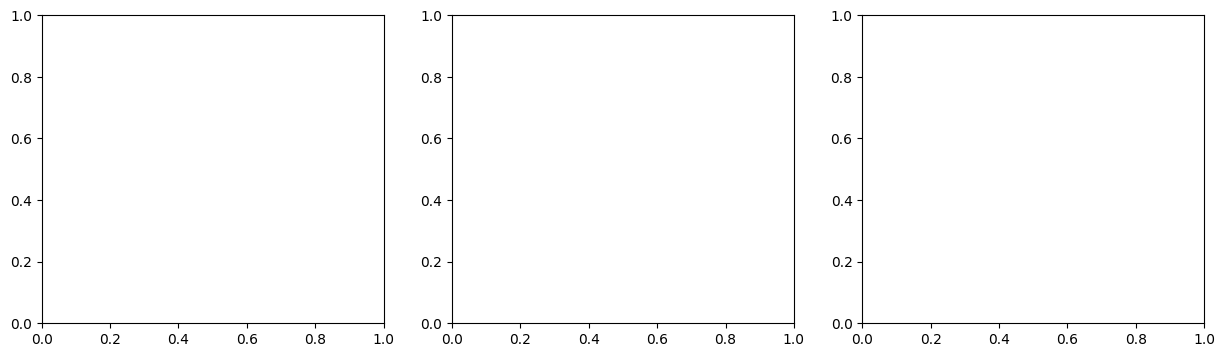

In [1]:
# Plot curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history["train_loss"], label="train")
axes[0].plot(history["val_loss"], label="val")
axes[0].axvline(best_epoch - 1, color="red", linestyle="--", alpha=0.5, label=f"best @ {best_epoch}")
axes[0].set_title("Total Loss")
axes[0].legend()

axes[1].plot(history["train_loc"], label="train")
axes[1].plot(history["val_loc"], label="val")
axes[1].set_title("Location Loss")
axes[1].legend()

axes[2].plot(history["train_str"], label="train")
axes[2].plot(history["val_str"], label="val")
axes[2].set_title("Strength Loss")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest val_loss: {best_val_loss:.6f} at epoch {best_epoch}")
print(f"Epochs after best: {len(history['val_loss']) - best_epoch}")
